## Stardist benchmark

In [1]:
import raster_geometry as rg
import numpy as np
from tnia.simulation.phantoms import add_small_to_large_2d
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import imshow_multi2d
import math
import numpy as np

In [6]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Built with GPU support?", tf.test.is_built_with_cuda())
print("GPU available to TensorFlow?", tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(gpu)
        print("Details:", details)
else:
    print("No GPU detected.")

TensorFlow version: 2.10.1
Built with GPU support? True
GPU available to TensorFlow? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Details: {'device_name': 'NVIDIA GeForce RTX 3090', 'compute_capability': (8, 6)}


## Make a super simple fake dataset

It only has 2 objects, object 1 with diameter of 6, object 2 with diameter of 140

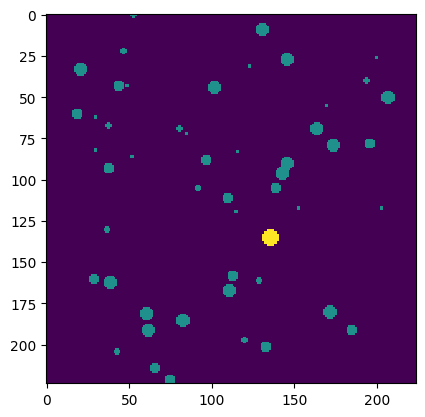

In [2]:
width, height = 224, 224

image = np.zeros([height, width], dtype=np.float32)
truth = np.zeros([height, width], dtype=np.float32)

x, y = 44, 44
r = 3 
size = [math.ceil(r*2), math.ceil(r*2)]
temp=rg.circle(size, r)
add_small_to_large_2d(image, temp, x, y, mode='replace_non_zero')
add_small_to_large_2d(truth, temp, x, y, mode='replace_non_zero')

x, y = 136, 136
r = 5 
size = [math.ceil(r*2), math.ceil(r*2)]
temp=rg.circle(size, r)
add_small_to_large_2d(image, temp, x, y, mode='replace_non_zero')
add_small_to_large_2d(truth, 2*temp, x, y, mode='replace_non_zero')


# random circles
for i in range(50):
    x, y = np.random.randint(0, width), np.random.randint(0, height)
    r = np.random.randint(1, 5)
    size = [math.ceil(r*2), math.ceil(r*2)]
    temp=rg.circle(size, r)
    add_small_to_large_2d(image, temp, x, y, mode='replace_non_zero')
    add_small_to_large_2d(truth, temp, x, y, mode='replace_non_zero')


plt.imshow(truth)

## Repeat the objects to make a fake training set

Just repeat a few times to make a trivial training set.  No need to even add blur or noise, we just want to see if a custom model can learn different scales. 

In [3]:
X = [image.copy().astype('float32')[..., np.newaxis] for i in range(10)]
Y = [truth.copy().astype('uint16') for i in range(10)]

## Make a custom model

In [4]:
from stardist.models import StarDist2D, Config2D
from tnia.deeplearning.dl_helper import augmenter

n_channel_in = 1
n_rays = 32
axes = 'YX'
config = Config2D (n_rays=n_rays, axes=axes,n_channel_in=n_channel_in, train_patch_size = (224,224), unet_n_depth=3)

model_path = './erase_me'

model = StarDist2D(config=config, name="model1", basedir=model_path)


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [5]:
import stardist
import tensorflow as tf
print (stardist.__version__)
print (tf.__version__)


# dplexbio311 45 seconds. 

model.train(X, Y, validation_data=(X,Y),epochs=5) 

0.8.5
2.10.1
Epoch 1/5
100/100 [==============================] - 16s 84ms/step - loss: 0.4829 - prob_loss: 0.1145 - dist_loss: 1.8422 - prob_kld: 0.0975 - dist_relevant_mae: 1.8420 - dist_relevant_mse: 5.8406 - dist_dist_iou_metric: 0.3502 - val_loss: 0.2562 - val_prob_loss: 0.0231 - val_dist_loss: 1.1652 - val_prob_kld: 0.0070 - val_dist_relevant_mae: 1.1650 - val_dist_relevant_mse: 2.5833 - val_dist_dist_iou_metric: 0.5071 - lr: 3.0000e-04
Epoch 2/5
100/100 [==============================] - 7s 66ms/step - loss: 0.1516 - prob_loss: 0.0191 - dist_loss: 0.6628 - prob_kld: 0.0029 - dist_relevant_mae: 0.6626 - dist_relevant_mse: 1.1567 - dist_dist_iou_metric: 0.6997 - val_loss: 0.1052 - val_prob_loss: 0.0183 - val_dist_loss: 0.4345 - val_prob_kld: 0.0021 - val_dist_relevant_mae: 0.4343 - val_dist_relevant_mse: 0.5338 - val_dist_dist_iou_metric: 0.8049 - lr: 3.0000e-04
Epoch 3/5
100/100 [==============================] - 7s 68ms/step - loss: 0.0934 - prob_loss: 0.0179 - dist_loss: 0.3771

In [21]:
for y in Y:
    print(y.min())

65525
65525
65525
65525
65525
65525
65525
65525
65525
65525
